In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [3]:
root_path = Path("/Users/adminnistrator/Documents/Stanford/STATS 207/STATS-207-Final-Project")

In [4]:
electricity_data = pd.read_csv(root_path / "clean_data.csv")

# Aggregate the data: compute the monthly average electricity price at the national level
electricity_data['date'] = pd.to_datetime(
    electricity_data[['year', 'month']].assign(day=1)
)  # Create a date column for time series analysis

# Calculate the monthly average price
national_avg_price = electricity_data.groupby('date')['price'].mean().reset_index()

national_avg_price.to_csv(root_path / "national_avg_price.csv", index = False)

In [10]:
national_avg_price['date'] = pd.to_datetime(national_avg_price['date'])
national_avg_price.set_index('date', inplace=True)
national_avg_price.head()

,price
date,
2001-01-01,7.136839
2001-02-01,7.271097
2001-03-01,7.443806
2001-04-01,7.544065
2001-05-01,7.675194


In [46]:
def create_lagged_features(data, lag=1):
    """
    Create lagged features for supervised learning.
    :param data: Input time series (numpy array or pandas Series).
    :param lag: Number of lagged observations to include.
    :return: Feature matrix X and target vector y.
    """
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

# Function to create and compile LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Explicit input layer
        LSTM(64, return_sequences=False),  # 64 units based on best params
        Dropout(0.1),  # Dropout rate
        Dense(1)  # Output layer
    ])
    optimizer = Adam(learning_rate=0.01)  # Learning rate
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [47]:
# 2. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(national_avg_price)

# Create lagged features with a window size of 12
lag = 12
X, y = create_lagged_features(data_normalized, lag)

# Reshape X for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [48]:
tscv = TimeSeriesSplit(n_splits=5)

# 4. Train and evaluate the model using cross-validation
results = []
rmse_values = []

train_losses = []
test_losses = []
all_predictions = []
all_actuals = []
fold = 1

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the LSTM model
    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test))

    # Training and Test Losses
    train_losses.append(history.history['loss'])
    test_losses.append(history.history['val_loss'])

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    results.append(loss)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

    # Store predictions and actuals for plotting
    all_predictions.append(y_pred)
    all_actuals.append(y_test)

    print(f"Fold {fold}:")
    print(f"  Loss: {loss:.4f}")
    print(f"  RMSE: {rmse:.4f}\n")

    fold += 1

# Print cross-validation results
print("Cross-validation summary:")
print(f"Cross-validation losses: {results}")
print(f"Mean loss: {np.mean(results):.4f}")
print(f"Cross-validation RMSE values: {rmse_values}")
print(f"Average RMSE: {np.mean(rmse_values):.4f}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0201 - val_loss: 0.0163
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0056 - val_loss: 0.0318
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0044 - val_loss: 0.0173
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036 - val_loss: 0.0342
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - val_loss: 0.0295
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030 - val_loss: 0.0179
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033 - val_loss: 0.0164
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034 - val_loss: 0.0268
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030 - val_loss: 0.0246
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0032 - val_loss: 0.0112
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021 - val_loss: 0.0104
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027 - val_loss: 0.0210
E

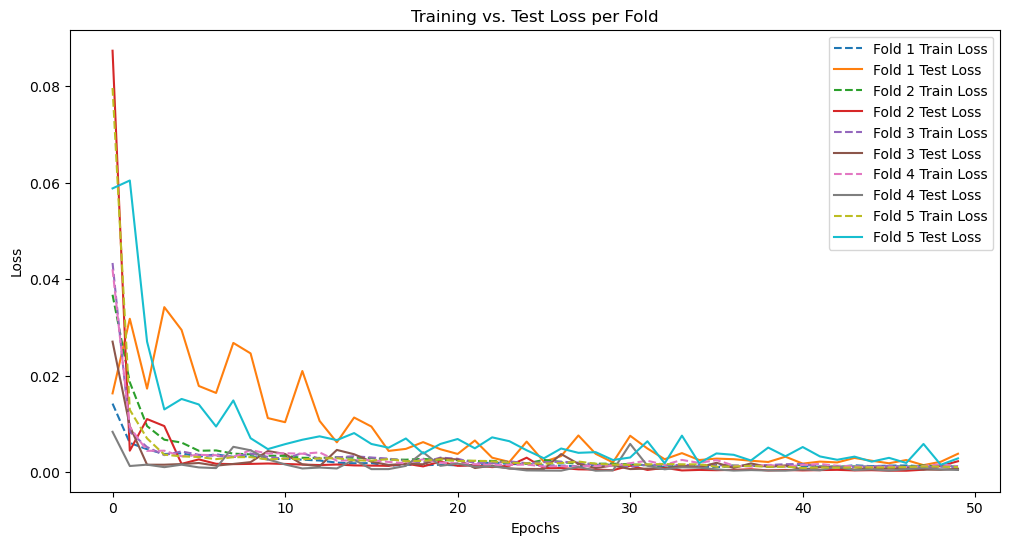

In [49]:
# 1. Plot Training and Test Losses
plt.figure(figsize=(12, 6))
for i, (train_loss, test_loss) in enumerate(zip(train_losses, test_losses)):
    plt.plot(train_loss, label=f'Fold {i+1} Train Loss', linestyle='--')
    plt.plot(test_loss, label=f'Fold {i+1} Test Loss')

plt.title('Training vs. Test Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

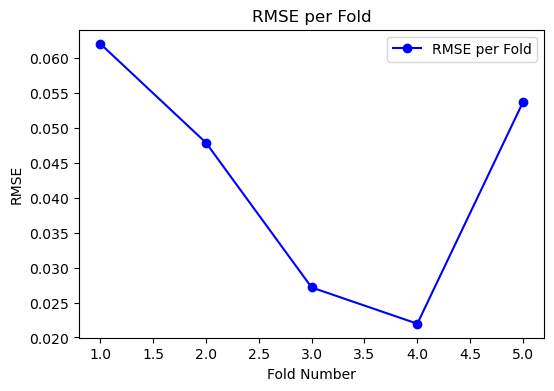

In [50]:
# 2. Plot RMSE per Fold
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', color='b', label='RMSE per Fold')
plt.title('RMSE per Fold')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.legend()
plt.show()

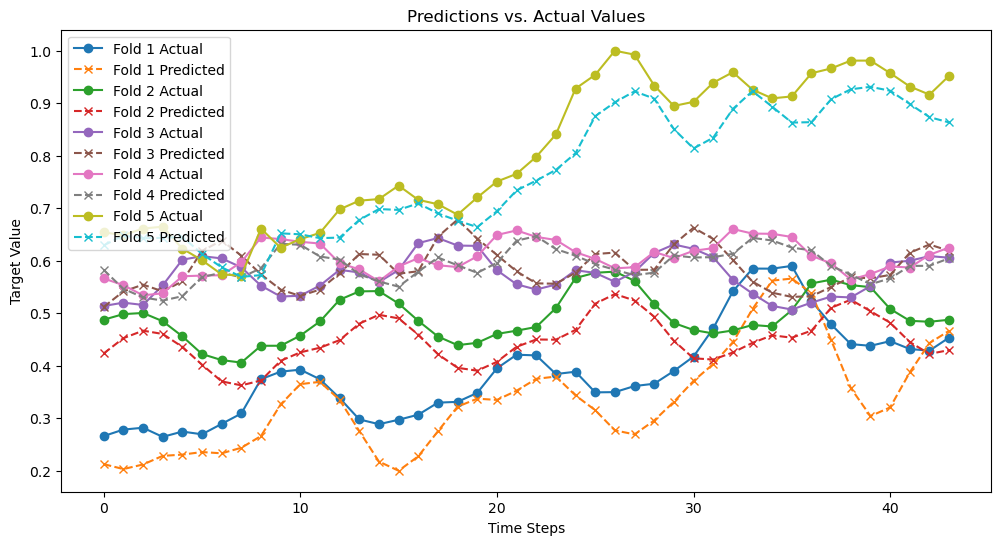

In [51]:
# 3. Plot Predictions vs. Actual Values
plt.figure(figsize=(12, 6))
for i in range(len(all_predictions)):
    plt.plot(all_actuals[i], label=f'Fold {i+1} Actual', linestyle='-', marker='o')
    plt.plot(all_predictions[i], label=f'Fold {i+1} Predicted', linestyle='--', marker='x')

plt.title('Predictions vs. Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Target Value')
plt.legend()
plt.show()